<a href="https://colab.research.google.com/github/reckoning-machines/sec_text_nlp/blob/master/sec_nlp_beta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#https://gist.github.com/Joshua1989/dc7e60aa487430ea704a8cb3f2c5d6a6
!mkdir sec_data_folder

In [2]:
!git clone https://gist.github.com/dc7e60aa487430ea704a8cb3f2c5d6a6.git /tmp/colab_util_repo
!mv /tmp/colab_util_repo/colab_util.py colab_util.py 
!rm -r /tmp/colab_util_repo
from colab_util import *
drive_handler = GoogleDriveHandler()

Cloning into '/tmp/colab_util_repo'...
remote: Enumerating objects: 40, done.
remote: Total 40 (delta 0), reused 0 (delta 0), pack-reused 40
Unpacking objects: 100% (40/40), done.


In [0]:
drive_handler.download('test_ticker_list.csv', target_path='test_ticker_list.csv')

In [7]:
import pandas as pd
df_tickers = pd.read_csv('test_ticker_list.csv')

for i, row in df_tickers.iterrows():
  str_ticker = row['Symbol']
  
  print('working for:'+str_ticker+"...")

  str_to_file = 'sec_data_folder/'+str_ticker+'.csv'
  str_from_file = '/sec_data_folder/'+str_ticker+'.csv'
  drive_handler.download(str_to_file, target_path=str_from_file)

working for:GOOG...
working for:FB...
working for:AMZN...
working for:HD...
working for:WMT...
working for:PG...
working for:XOM...
working for:CVX...
working for:JPM...
working for:BAC...
working for:JNJ...
working for:UNH...
working for:LMT...
working for:UNP...
working for:MSFT...
working for:AAPL...
working for:LIN...
working for:ECL...
working for:AMT...
working for:CCI...
working for:NEE...
working for:D...


In [21]:
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('stopwords')

import pandas as pd

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize

#replace with your own list of words ... like covid or delay or cancel (it lowercases automatically)
FIND_WORDS = ['movie',
              'acting',
              'story']

def check_if_list_found_in_text(text, words=[], return_offset=False, lower_text=True):
    result = []
    text = (
        " "
        + text.replace("_", " ")
        .replace("-", " ")
        .replace(",", " ")
        .replace(";", " ")
        .replace('"', " ")
        .replace(":", " ")
        .replace(".", " ")
        + " "
    )
    if lower_text:
        text = text.lower()
    for word in words:
        word = (
            " "
            + word.replace("_", " ")
            .replace("-", " ")
            .replace(",", " ")
            .replace(";", " ")
            .replace('"', " ")
            .replace(":", " ")
            .replace(".", " ")
            + " "
        )
        if lower_text:
            word = word.lower()
        if word in text:
            if return_offset:
                offset = text.find(word)
                # offset = offset if not offset else offset-1
                result.append(offset)
            else:
                result.append(word.strip())
    return result
def filter_stopwords(sent):
    stop_words = set(stopwords.words('english'))   
    word_tokens = word_tokenize(sent)   
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w)
    return ' '.join(filtered_sentence)

def df_from_text(text):
    sentence_list = tokenize.sent_tokenize(text)
    sentence_list
    sid = SentimentIntensityAnalyzer()
    list_df = []
    for sentence in sentence_list:
        sentence = filter_stopwords(sentence)
        list_found = check_if_list_found_in_text(sentence,FIND_WORDS)
        num_found = len(list_found)
        ss = sid.polarity_scores(sentence)
        df = pd.DataFrame.from_dict(ss,orient = "index").T
        df['text'] = sentence
        df['keywords_found'] = num_found 
        list_df.append(df)
    return pd.concat(list_df)

df_text = pd.read_csv("sec_data_folder/WMT.csv") #replace with your own dataset



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
df_discussion = df_text[df_text['section']=='discussion']

list_df = []
for i,row in df_discussion.iterrows():
    df = df_from_text(row['text']) #replace with your own text column name
    df['id'] = i #this would be "slack message id" basically
    df['period_date'] = row['period_date']
    df['type'] = row['type']
    df['section'] = row['section']
    list_df.append(df)

df_sentence_text_scores = pd.concat(list_df)

In [39]:
df_grouped = df_sentence_text_scores.groupby(['period_date','type']).sum().reset_index()
df_grouped

,period_date,type,neg,neu,pos,compound,keywords_found,id
0,2018-10-31T00:00:00Z,10-Q,9.501,269.816,39.683,71.4373,0,266996
1,2019-01-31T00:00:00Z,10-K,13.797,323.088,56.116,95.8049,0,269967
2,2019-04-30T00:00:00Z,10-Q,7.125,228.764,37.113,64.9429,0,143937
3,2019-07-31T00:00:00Z,10-Q,7.770,233.661,37.575,68.6423,0,107942
4,2019-10-31T00:00:00Z,10-Q,8.177,242.064,37.765,71.0630,0,70029
5,2020-01-31T00:00:00Z,10-K,15.920,341.484,58.600,96.9109,0,36735


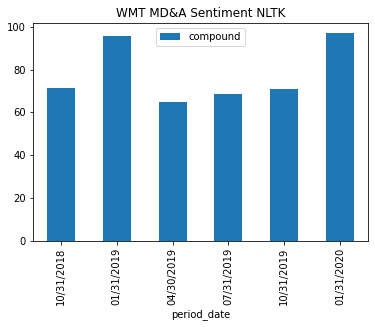

In [50]:

df_grouped['period_date'] = pd.to_datetime(df_grouped['period_date'])
df_grouped['period_date'] = df_grouped['period_date'].dt.strftime('%m/%d/%Y')
df_grouped.plot(x='period_date',y='compound',kind = 'bar',title = 'WMT MD&A Sentiment NLTK')
